In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tensor_type import Tensor
from typing import List, Tuple, Callable, Union, Optional
import pdb

D = 2   # dimension

In [2]:
class SV:
    '''
        Assumes: 
        -potential function is given
    '''
    def __init__(self, U, h, dim):
        self.U   = U
        self.h   = h
        self.dim = dim
            
    def gradient(self,
                 func: Callable,
                 x:    Tensor) -> Tuple[Tensor, Tensor]:
        '''
        dH calculates callable function and its gradient.
        x: tensor
        Mat: tensor (mass matrix)
        func: is a function to calculate
        returns function output and gradient
        '''
        x.requires_grad_(True)    # track math operations
        x.retain_grad()           # keep gradient after backward()
        out    = func(x)          # calculate given function
        out.backward(gradient=torch.ones(out.size()))  # Calculate grads
        x_grad = x.grad.data      # get gradients only
        x.grad = None             # reset gradient 
        x.requires_grad_(False)   # stop tracking
        return out.detach().clone(), x_grad 

    def sv1(self, p,q):
                                  # half-step p
        _, g1 = self.gradient(self.U, q)
        p     -= .5*self.h*g1
                                  # full-step q
        q     += self.h*p
                                  # half-step p
        _, g2 = self.gradient(self.U, q)
        p     -= .5*self.h*g2
        
        return -p,q

class HMC():
    def __init__(self,
                 method,
                 potential,
                 M=torch.eye(D),
                 updateM=False):
        self.method = method  # Callable integration method
        self.U      = potential
        self.M      = M
        self.Mi     = torch.inverse(M)
        
        
    def K(self, p):
        return torch.squeeze( (p.t()@self.Mi@p)*.5 )
    
    def dK(self,p):
        return torch.squeeze( self.Mi@p)
        
    def H(self, p, q):
        return torch.squeeze( self.K(p) + self.U(q))
    
    def alpha(self, p0,q0,pstar,qstar):
        a = torch.Tensor([1., torch.exp(self.H(p0,q0)-\
                                        self.H(pstar,qstar))])
        return (torch.min(a)).item()
    def accept(self, a, q0, qstar):
        acceptFlag = False
        u = np.random.uniform(0,1)
        if u < a:
            q0 = qstar
            acceptFlag = True
        else:
            q0 = q0
            acceptFlag = False
        return q0, acceptFlag
    
    def sample(self, q0):
        p0 = torch.randn((2,1))        # sample normal dist
        Pp,Qp = self.method(p0,q0)     # propagate
        acc = self.alpha(p0,q0,Pp,Qp)  # get acceptance prob
        return  self.accept(acc, q0, Qp)    # accept/reject

In [6]:
a = .5
b = 5.
Cov = torch.Tensor([[1.,0.],[0.,1.]])
Cov[0,0] *= a
Cov[1,1] *= b
iCov = torch.inverse(Cov)

def eccentricity(smajor, sminor):
    return np.sqrt(1. - (sminor**2)/(smajor**2))

def U(q):
        return torch.squeeze( q.t()@iCov@q )
Nprops = 100000
H = .2  # stepsize
sv = SV(U,H,D)
hmc = HMC(sv.sv1, U)

q0 = torch.Tensor([[10.],[10.]])
samples = np.zeros((D,Nprops))
acceptance_count = 0

In [7]:
%%time
for n in range(Nprops):
    q0, accFlag = hmc.sample(q0)
    if(accFlag):
        acceptance_count += 1
    samples[:,n] = q0.numpy()[:,0]

CPU times: user 3min 23s, sys: 8min 4s, total: 11min 27s
Wall time: 43.4 s


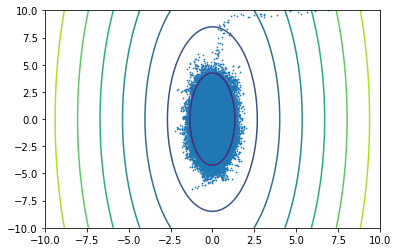

 Acceptance rate = 1.0


In [8]:
bnd = 10
delta = 0.025

x = np.arange(-bnd, bnd, delta)
y = np.arange(-bnd, bnd, delta)
X, Y = np.meshgrid(x, y)
Z = np.sqrt(b*X**2 + a*Y**2)

plt.figure()
CS = plt.contour(X, Y, Z)
plt.scatter(samples[0,:],samples[1,:], s=.5)
plt.xlim(-bnd,bnd)
plt.ylim(-bnd,bnd)
plt.show()

print(f' Acceptance rate = {acceptance_count/Nprops}')